# Optical Bloch Equations

We will derive here the explicit form of optical Bloch equations in the electric dipole approximation (EDA), the rotating wave approximation (RWA), in the rotating frame (RF).

In [1]:
from sympy import symbols, IndexedBase, Idx, Sum, init_printing
from sympy.physics.quantum import Bra, Ket, State

from sympy.physics.quantum import Bra, Ket, State
from sympy.core.basic import sympify
from sympy.core.compatibility import string_types, range
from sympy.physics.quantum.hilbert import ComplexSpace
from sympy import Integer, KroneckerDelta
from sympy import diff, exp, I
from sympy import Matrix

init_printing()

In [2]:
class AtomicState(State):
    """Base class for Qubit and QubitBra."""

    #-------------------------------------------------------------------------
    # Initialization/creation
    #-------------------------------------------------------------------------
    def __init__(self, *args):
        self.thisthis = 2

    @classmethod
    def _eval_args(cls, args):
        # If we are passed a QubitState or subclass, we just take its qubit
        # values directly.
        if len(args) == 1 and isinstance(args[0], AtomicState):
            return args[0].qubit_values

        # Turn strings into tuple of strings
        if len(args) == 1 and isinstance(args[0], string_types):
            args = tuple(args[0])

        # args = sympify(args)

        # Validate input (must have 0 or 1 input)
        # print 111
        # for element in args:
        #     if not (element == 1 or element == 0):
        #         raise ValueError(
        #             "Qubit values must be 0 or 1, got: %r" % element)
        return args

    @classmethod
    def _eval_hilbert_space(cls, args):
        return ComplexSpace(2)**len(args)

    #-------------------------------------------------------------------------
    # Properties
    #-------------------------------------------------------------------------

    @property
    def dimension(self):
        """The number of Qubits in the state."""
        return len(self.qubit_values)

    @property
    def nqubits(self):
        return self.dimension

    @property
    def qubit_values(self):
        """Returns the values of the qubits as a tuple."""
        return self.label


class AtomicKet(AtomicState, Ket):
    """A multi-qubit ket in the computational (z) basis."""

    @classmethod
    def dual_class(self):
        return AtomicBra

    def _eval_innerproduct_AtomicBra(self, bra, **hints):
        if self.label == bra.label:
            return Integer(1)
        else:
            return KroneckerDelta(bra.label[0], self.label[0])

class AtomicBra(AtomicState, Bra):
    """A multi-qubit bra in the computational (z) basis."""
    @classmethod
    def dual_class(self):
        return Atomic

We begin with an undisturbed Hamiltonian $\hat{H}_0$ with $N_e$ eigenvectors $|i\rangle$ ordered by their energies $\mathrm{E}_i= \hbar \omega_i$.

In [3]:
hbar, e = symbols("hbar e", positive=True)
Ne = symbols("N_e", integer=True)
i, j, k = symbols('i j k', cls=Idx)
Energy = IndexedBase('\mathrm{E}', shape=(Ne,))
omega_level = IndexedBase('omega', shape=(Ne,))

In [4]:
Energy[i], omega_level[i]

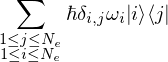

In [5]:
H0 = hbar*omega_level[i]*KroneckerDelta(i,j)
H0s = Sum( H0*AtomicKet(i)*AtomicBra(j), (j, 1, Ne), (i, 1, Ne))
H0s

We wish to model the interaction of this atom with an electric field that can be decomposed into $N_l$ discrete, well-defined frequencies.

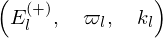

In [6]:
Nl = symbols("N_l", integer=True)

E0p = IndexedBase("E^{(+)}", shape=(Nl,))
E0m = IndexedBase("E^{(-)}", shape=(Nl,))
omega_laser = IndexedBase("varpi", shape=(Nl,))
k_laser = IndexedBase("k", shape=(Nl,))
l = symbols("l", cls=Idx)

E0p[l], omega_laser[l], k_laser[l]

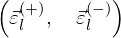

In [7]:
t, R = symbols("t, R", real=True)
epsilonp = IndexedBase(r"\vec{\varepsilon}^{(+)}", shape=(Nl,))
epsilonm = IndexedBase(r"\vec{\varepsilon}^{(-)}", shape=(Nl,))
epsilonp[l], epsilonm[l]

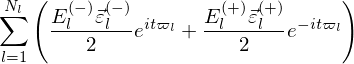

In [8]:
Ep = E0p[l]*epsilonp[l]/2 * exp(-I*(omega_laser[l]*t))
Em = E0m[l]*epsilonm[l]/2 * exp( I*(omega_laser[l]*t))

Eps = Sum(Ep, (l, 1, Nl))
Ems = Sum(Em, (l, 1, Nl))

E = Ep + Em

Es = Sum(E, (l, 1, Nl))
Es

Such that $E_l^{\pm}=(E_l^{\mp})^{\ast}$ are space dependant functions, and $\vec{\varepsilon}_l^{\pm}=(\vec{\varepsilon}_l^{\mp})^{\ast}$ are space dependant unitary vectors. In particular, if the fields are plane waves,

\begin{equation}
    E_l^{\pm} = E_{0l} \exp(\pm i \vec{k}_l \cdot \vec{R})
\end{equation}

So, $E_l^{\pm}$ encode the spacial structure of the fields, and $\vec{\varepsilon}_l^{\pm}$ the spacial structure of the polarization.

The atoms have some electric dipole operator

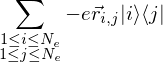

In [9]:
r = IndexedBase(r"\vec{r}", shape=(Ne,Ne))
d = Sum(-e*r[i,j]*AtomicKet(i)*AtomicBra(j), (i, 1, Ne), (j,1,Ne))
d

which we can similarly divide in positive and negative frequency components (that appear in the interaction picture).

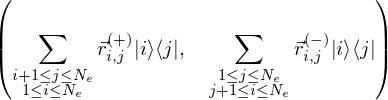

In [10]:
rp = IndexedBase(r"\vec{r}^{(+)}", shape=(Ne,Ne))
rm = IndexedBase(r"\vec{r}^{(-)}", shape=(Ne,Ne))

#rp = rp[i, j]# *AtomicKet(i)*AtomicBra(j)
#rm = rm[i, j]# *AtomicKet(i)*AtomicBra(j)

r = rp + rm

rps = Sum(rp[i, j]*AtomicKet(i)*AtomicBra(j), (j,i+1,Ne), (i, 1, Ne))
rms = Sum(rm[i, j]*AtomicKet(i)*AtomicBra(j), (j, 1, Ne), (i, j+1, Ne))

rps, rms

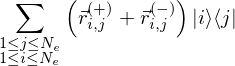

In [11]:
rs = Sum((rp[i, j]+rm[i, j])*AtomicKet(i)*AtomicBra(j), (j, 1, Ne), (i, 1, Ne))
rs

Which is a rather elaborate way of saying that the operator can be separated in the components above (+) and below (-) of the diagonal.

# The rotating wave approximation
In the electric dipole approximation, the interaction hamiltonian is

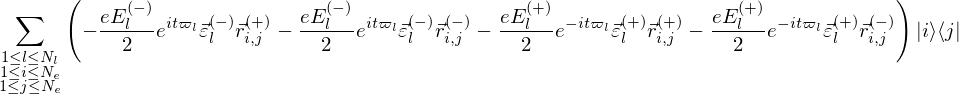

In [12]:
H1E1 = -e*rp[i, j]*Ep  -e*rp[i, j]*Em  -e*rm[i, j]*Ep -e*rm[i, j]*Em

H1E1s = Sum(H1E1*AtomicKet(i)*AtomicBra(j), (l, 1, Nl), (i, 1, Ne), (j, 1, Ne))
H1E1s

In the rotating wave approximation, this is approximated by

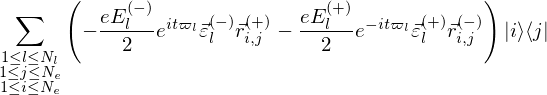

In [13]:
H1E1RWA = -e*rp[i, j]*Em  -e*rm[i, j]*Ep
H1E1RWAs = Sum(H1E1RWA*AtomicKet(i)*AtomicBra(j), (l, 1, Nl), (j, 1, Ne), (i, 1, Ne))

H1E1RWAs

And the full hamiltonian is

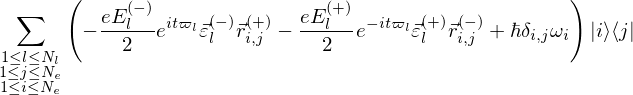

In [14]:
HE1RWA = H0 + H1E1RWA
HE1RWAs = Sum(HE1RWA*AtomicKet(i)*AtomicBra(j), (l, 1, Nl), (j, 1, Ne), (i, 1, Ne))

HE1RWAs

# The rotating frame
We make an arbitrary phase transformation on an arbitrary atomic state

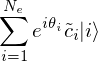

In [15]:
c = IndexedBase(r"c", shape=(Ne,))
ct = IndexedBase(r"\tilde{c}", shape=(Ne,))
theta = IndexedBase(r"\theta", shape=(Ne,))

psi = ct[i]*exp(I*theta[i])*AtomicKet(i)
psis = Sum(psi, (i, 1, Ne))
psis

The Schrödinger equation is

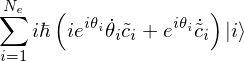

In [16]:
ctp = IndexedBase(r"\dot{\tilde{c}}", shape=(Ne,))
thetap = IndexedBase(r"\dot{\theta}", shape=(Ne,))


lhs = I*hbar*(exp(I*theta[i])*ctp[i]+I*thetap[i]*exp(I*theta[i])*ct[i])*AtomicKet(i)
lhss = Sum(lhs, (i, 1, Ne))
lhss

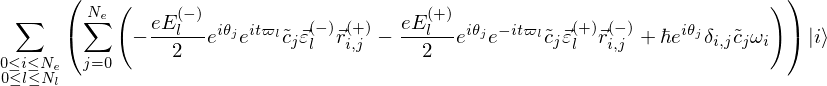

In [17]:
rhs = HE1RWA.subs({j: k})*psi.subs({i: k})
rhs = rhs.expand()
rhs = rhs.subs({AtomicKet(k): 1}).subs({AtomicBra(k): 1})
rhs = rhs.subs({k: j})
rhs = Sum(rhs, (j, 0, Ne))

rhss = Sum(rhs*AtomicKet(i), (i, 0, Ne), (l, 0, Nl))
rhss

And now, component-wise, we multiply by $e^{-i\theta_i}$ and add $\hbar \dot{\theta}_i\tilde{c}_i$

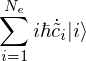

In [18]:
lhs_tilde = lhs.subs({AtomicKet(i):1})*exp(-I*theta[i])
lhs_tilde = lhs_tilde.expand()
lhs_tilde = lhs_tilde + hbar*thetap[i]*ct[i]

lhs_tildes = Sum(lhs_tilde*AtomicKet(i), (i, 1, Ne))

lhs_tildes

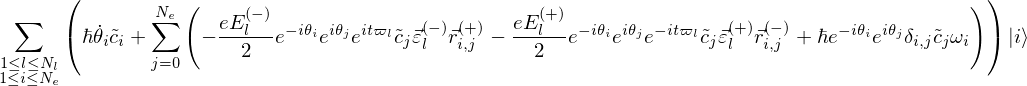

In [19]:
rhs_tilde = rhs.subs({AtomicKet(i):1})
rhs_tilde = Sum((rhs_tilde.args[0]*exp(-I*theta[i])).expand(), rhs_tilde.args[1])
rhs_tilde = rhs_tilde + hbar*thetap[i]*ct[i]

rhs_tildes = Sum(rhs_tilde*AtomicKet(i), (l, 1, Nl), (i, 1, Ne))
rhs_tildes

We can bring the first tem into the $j$ sum

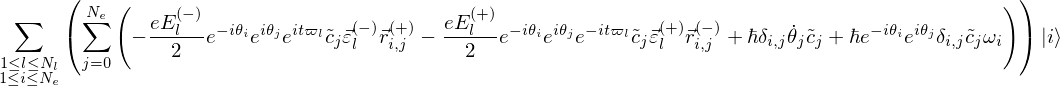

In [20]:
rhs_tilde2 = Sum(rhs_tilde.args[1].args[0]+rhs_tilde.args[0].subs({i: j})*KroneckerDelta(i,j), rhs_tilde.args[1].args[1])

rhs_tildes = Sum(rhs_tilde2*AtomicKet(i), (l, 1, Nl), (i, 1, Ne))
rhs_tildes

So we can see that the condition for the elimination of explicit time dependence is that $\dot{\theta}_j$ is a constant, and that

In [21]:
eqs_phase = -theta[i]+theta[j]+t*omega_laser[l]
eqs_phase

for $j>i$. Notice that equations

In [22]:
eqs_phase2 = -theta[i]+theta[j]-t*omega_laser[l]
eqs_phase2

for $i>j$ are equivalent, since these terms are multiplied by $\vec{r}^{(\pm)}_{ij}$ respectively, and only one of them is non-zero for given $i, j$.

We further make the approximation that not all $N_l$ fields are coupled to all transitions $|i\rangle\rightarrow |j\rangle$. So we define a symbol $\xi_{lij}$ that is 1 if field $l$ couples the transition $|i\rangle\rightarrow |j\rangle$ and zero otherwise. Thus we can rewrite the right hand side as

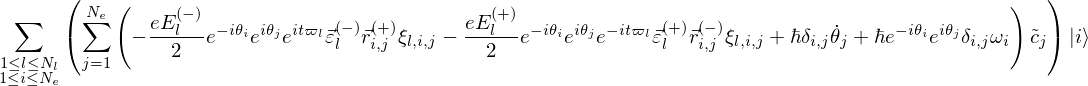

In [23]:
xi = IndexedBase("xi", shape=(Nl, Ne, Ne))

rhs_tilde3=rhs_tilde2.args[0].subs({E0m[l]: E0m[l]*xi[l, i, j], E0p[l]: E0p[l]*xi[l, i, j]})
rhs_tilde3=rhs_tilde3.subs({ct[j]:1})*ct[j]

rhs_tilde3=Sum(rhs_tilde3, (j, 1, Ne))

rhs_tildes = Sum(rhs_tilde3*AtomicKet(i), (l, 1, Nl), (i, 1, Ne))
rhs_tildes

So it can be seen that this is a Schrödinger equation from an effective Hamiltonian

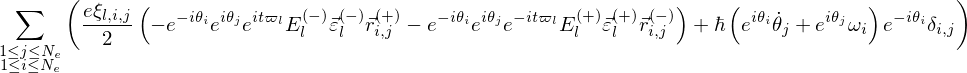

In [24]:
H_tilde = rhs_tilde3.args[0].subs({ct[j]:1})
ss = {xi[l, i, j]: 1, e:1, E0p[l]: E0p[l]*2, E0m[l]: E0m[l]*2}
H_tilde = (H_tilde.args[0]+H_tilde.args[1]).factor() + (H_tilde.args[2]+H_tilde.args[3]).subs(ss)*(e*xi[l, i, j]/2)

H_tildes = Sum(H_tilde, (j, 1, Ne), (i, 1, Ne))
H_tildes

Then to eliminate the time dependence is

In [25]:
eqs_phase

for all $j > i$ such that $\xi_{lij}=1$. If these equations are satisfied for some set of $\theta_i$, then the equations become

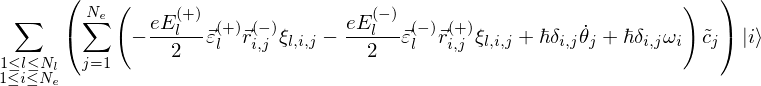

In [26]:
ss_phase = {exp(-I*theta[i]):1, exp(-I*theta[j]):1, exp(-I*t*omega_laser[l]):1}
rhs_tilde4 = Sum(rhs_tilde3.args[0].subs(ss_phase), (j, 1, Ne))

rhs_tildes = Sum(rhs_tilde4*AtomicKet(i), (l, 1, Nl), (i, 1, Ne))
rhs_tildes

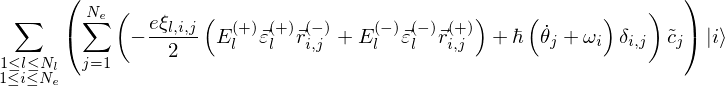

In [27]:
terms = rhs_tilde4.args[0].subs({ct[j]:1}).args
rhs_tilde5 = (terms[0]+terms[1]).factor() + (terms[2]+terms[3]).factor()
rhs_tilde5 = Sum(rhs_tilde5*ct[j], (j, 1, Ne))

rhs_tildes = Sum(rhs_tilde5*AtomicKet(i), (l, 1, Nl), (i, 1, Ne))
rhs_tildes

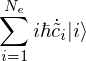

In [28]:
lhs_tildes

So we can see that this is the Schrödinger equation from an effective hamiltonian

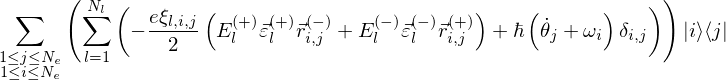

In [29]:
H_tilde = Sum(rhs_tilde5.args[0].subs({ct[j]:1}), (l, 1, Nl))

H_tildes = Sum(H_tilde*AtomicKet(i)*AtomicBra(j), (j, 1, Ne), (i, 1, Ne))
H_tildes

We can define a generalized Rabi frequency $\Omega_{lij}^{(\pm\mp)} \equiv e\xi_{lij} E_l^{(\pm)}\vec{\varepsilon}_l^{(\pm)}\vec{r}_{ij}^{(\mp)}/\hbar$

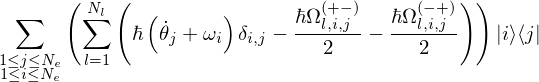

In [30]:
Omegapm = IndexedBase(r"\Omega^{(+-)}", shape=(Nl, Ne, Ne))
Omegamp = IndexedBase(r"\Omega^{(-+)}", shape=(Nl, Ne, Ne))

sOmega = {E0p[l]: hbar*Omegapm[l, i, j]/epsilonp[l]/rm[i, j]/e,
          E0m[l]: hbar*Omegamp[l, i, j]/epsilonm[l]/rp[i, j]/e,
          xi[l, i, j]: 1, e: 1}

H_tilde2 = H_tilde.args[0].subs(sOmega)
H_tilde2 = Sum(H_tilde2, (l, 1, Nl))

H_tildes = Sum(H_tilde2*AtomicKet(i)*AtomicBra(j), (j, 1, Ne), (i, 1, Ne))
H_tildes

Notice that if $\Omega_{lij}^{(+-)} \neq 0$, then $\Omega_{lij}^{(-+)}=0$. However, $\Omega_{lij}^{(+-)} = (\Omega_{lji}^{(-+)})^*$.

# Time evolution

The state of a quantum system is described by its density matrix $\hat{\rho}$, which component-wise is

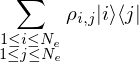

In [31]:
rho = IndexedBase(r"\rho", shape=(Ne, Ne))

rhos = Sum(rho[i, j]*AtomicKet(i)*AtomicBra(j), (i, 1, Ne), (j, 1, Ne))
rhos

And in the rotating frame, we have

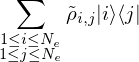

In [32]:
rhot = IndexedBase(r"\tilde{\rho}", shape=(Ne, Ne))

rhots = Sum(rhot[i, j]*AtomicKet(i)*AtomicBra(j), (i, 1, Ne), (j, 1, Ne))
rhots

So that

In [33]:
eqsign = symbols("=")
Matrix([rhot[i, j], eqsign, rho[i, j]*exp(I*(theta[i]-theta[j]))]).transpose()

The time evolution of the density matrix of our atomic ensemble is given by
\begin{equation}
    \dot{\hat{\tilde{\rho}}} = \frac{i}{\hbar} [\hat{\tilde{\rho}}, \hat{H}]
\end{equation}

Which component-wise is

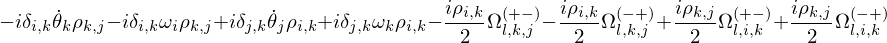

In [34]:
H_tilde3=H_tilde2.args[0]
rhs = I/hbar * (rho[i, k]*H_tilde3.subs({i:k}) - H_tilde3.subs({j:k})*rho[k, j])
rhs = rhs.expand()
rhs